In [149]:
import torch
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.weight'] = "bold"
plt.rcParams['legend.framealpha'] = 0

/work/albertl_uri_edu/.conda/envs/f2f_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
##taken from aqua_argo_prepro script

In [12]:
x = xr.open_dataset('../data/GLDAS/GLDAS_NOAH025_M.A200107.021.nc4')
x

<xarray.Dataset>
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 2001-07-01
  * lon                    (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * lat                    (lat) float32 -59.88 -59.62 -59.38 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] ...
    Swnet_tavg             (time, lat, lon) float32 ...
    Lwnet_tavg             (time, lat, lon) float32 ...
    Qle_tavg               (time, lat, lon) float32 ...
    Qh_tavg                (time, lat, lon) float32 ...
    Qg_tavg                (time, lat, lon) float32 ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 ...
    Tair_f_inst            (time, lat, lon) float32 ...
    Qair_f_inst            (time, lat, lon) float32 ...
    Psurf_f_inst           (time, lat, lon) float32 ...
    SWdown_f_tavg          (time, lat, lon) float32 ...
    LWdown_f_tavg          (time, lat, lon) float32 ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-10-30T04:22:24.381
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [19]:
Qs_GLDAS = x.Qs_acc
Qsb_GLDAS = x.Qsb_acc

print(Qs_GLDAS.shape,Qsb_GLDAS.shape)

(1, 600, 1440) (1, 600, 1440)


In [10]:
#now i want to get sst.

In [11]:
x1 = xr.open_dataset('../data/MODIS/AQUA_MODIS.20020701_20020731.L3m.MO.NSST.sst.9km.nc')
x1

<xarray.Dataset>
Dimensions:   (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon       (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 ...
    qual_sst  (lat, lon) float32 ...
    palette   (rgb, eightbitcolor) uint8 ...
Attributes: (12/59)
    product_name:                     AQUA_MODIS.20020701_20020731.L3m.MO.NSS...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   26-day
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        4552793
    data_minimum:                     -1.675
    data_maximum:                     35.015

In [18]:
sst = x1.sst
print(sst.shape)

(2160, 4320)


In [27]:
regridding_object = xe.Regridder(Qs_GLDAS,sst,method='bilinear')

/work/albertl_uri_edu/.conda/envs/f2f_2/lib/python3.10/site-packages/xarray/core/dataarray.py:853: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [28]:
print('done')

done


In [29]:
regridding_object.to_netcdf()

'bilinear_600x1440_2160x4320.nc'

In [74]:
z = regridding_object(Qs_GLDAS)
z = np.where(z==0,np.nan,z)

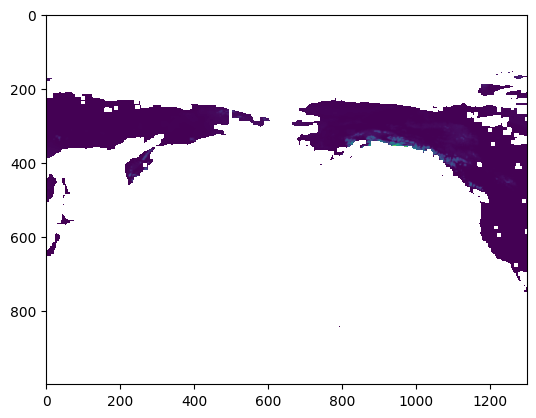

In [76]:
fig = plt.figure()

plt.imshow(np.roll(z[0],1000)[:1000,500:1800])

In [67]:
z.shape

(1, 2160, 4320)

In [109]:
sst

<xarray.DataArray 'sst' (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Attributes:
    long_name:      Sea Surface Temperature
    units:          degree_C
    standard_name:  sea_surface_temperature
    valid_min:      -1000
    valid_max:      10000
    display_scale:  linear
    display_min:    -2.0
    display_max:    45.0

In [110]:
sst.median()

<xarray.DataArray 'sst' ()>
array(21.34000015)

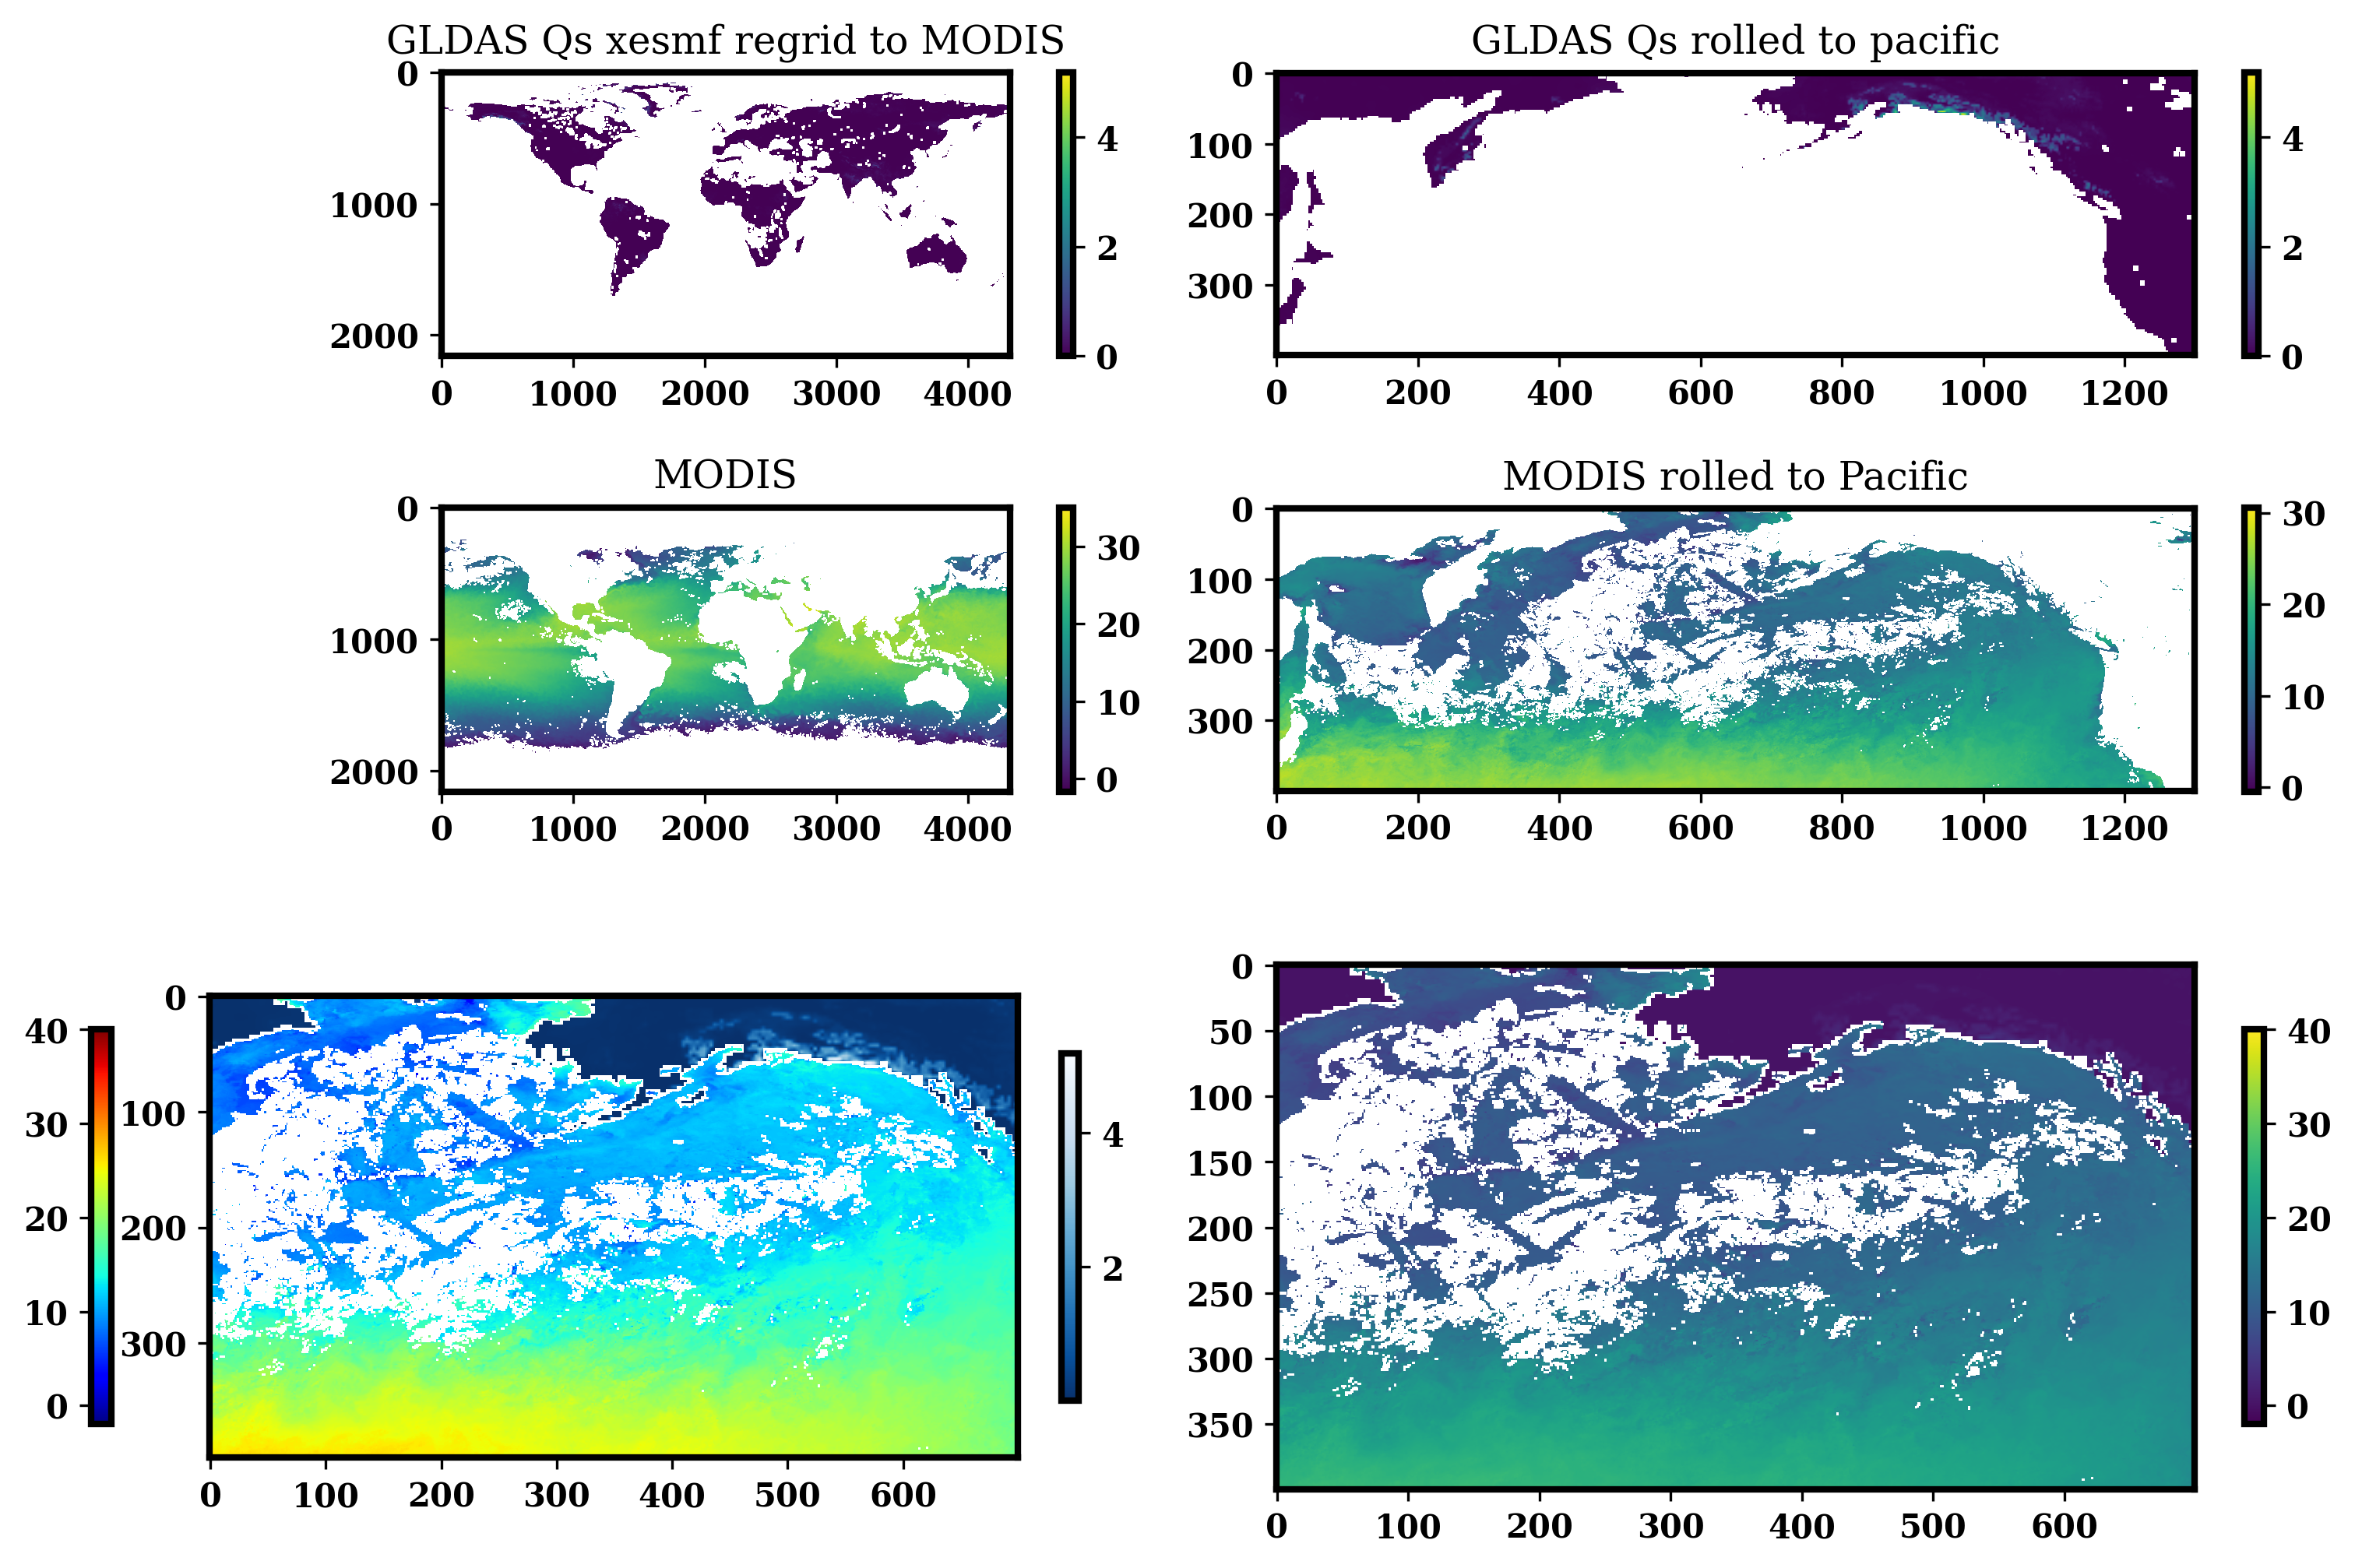

In [206]:
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(nrows=3,ncols=2,hspace=.4,wspace=.2,width_ratios=[.5,.5],height_ratios=[.25,.25,.50])

a1 = np.roll(z[0],1000)[300:700,500:1800]
a2 = np.roll(sst,1000)[300:700,500:1800]
sst_median = sst.median()
b = np.where(np.isnan(a1) == True, a2, a1) 


fig.add_subplot(gs[0,0])
plt.imshow(z[0])
plt.title('GLDAS Qs xesmf regrid to MODIS')
plt.colorbar(fraction=.02)


fig.add_subplot(gs[0,1])
plt.imshow(a1)
plt.title('GLDAS Qs rolled to pacific')
plt.colorbar(fraction=.02)


fig.add_subplot(gs[1,0])
plt.imshow(sst)
plt.title('MODIS')
plt.colorbar(fraction=.02)


fig.add_subplot(gs[1,1])
plt.imshow(a2)
plt.title('MODIS rolled to Pacific')
plt.colorbar(fraction=.02)


fig.add_subplot(gs[2,0])
plt.imshow(np.where(np.isnan(a1) == True, a2,np.nan)[:400,400:1100],cmap='jet',vmin=-2,vmax=40)
plt.gca().set_aspect('equal')
plt.colorbar(fraction=.02,location='left')
plt.imshow(np.where(np.isnan(a1) == False, a1, np.nan)[:400,400:1100],cmap='Blues_r')
plt.colorbar(fraction=.02)


fig.add_subplot(gs[2,1])
plt.imshow(b[:,400:1100],vmin=-2,vmax=40)
plt.colorbar(fraction=.02)


In [207]:
a2.shape

(400, 1300)

In [208]:
A2 = torch.from_numpy(a2).unsqueeze(0).unsqueeze(0)
print(A2.shape)

patchsize = 100
unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))
mask_patches = unfoldobj(A2).permute(2,0,1).reshape(-1,1,patchsize,patchsize)

torch.Size([1, 1, 400, 1300])


In [209]:
mask_patches.shape

torch.Size([52, 1, 100, 100])

In [210]:
def foldit(x):
    x0 = x.reshape(-1,1,x.shape[2]*x.shape[3]).permute(1,2,0)
    fold = torch.nn.Fold(output_size=(A2.shape[2],A2.shape[3]),kernel_size=(patchsize,patchsize),stride=(patchsize,patchsize))
    return fold(x0)

yo = foldit(mask_patches)
yo.shape

torch.Size([1, 1, 400, 1300])

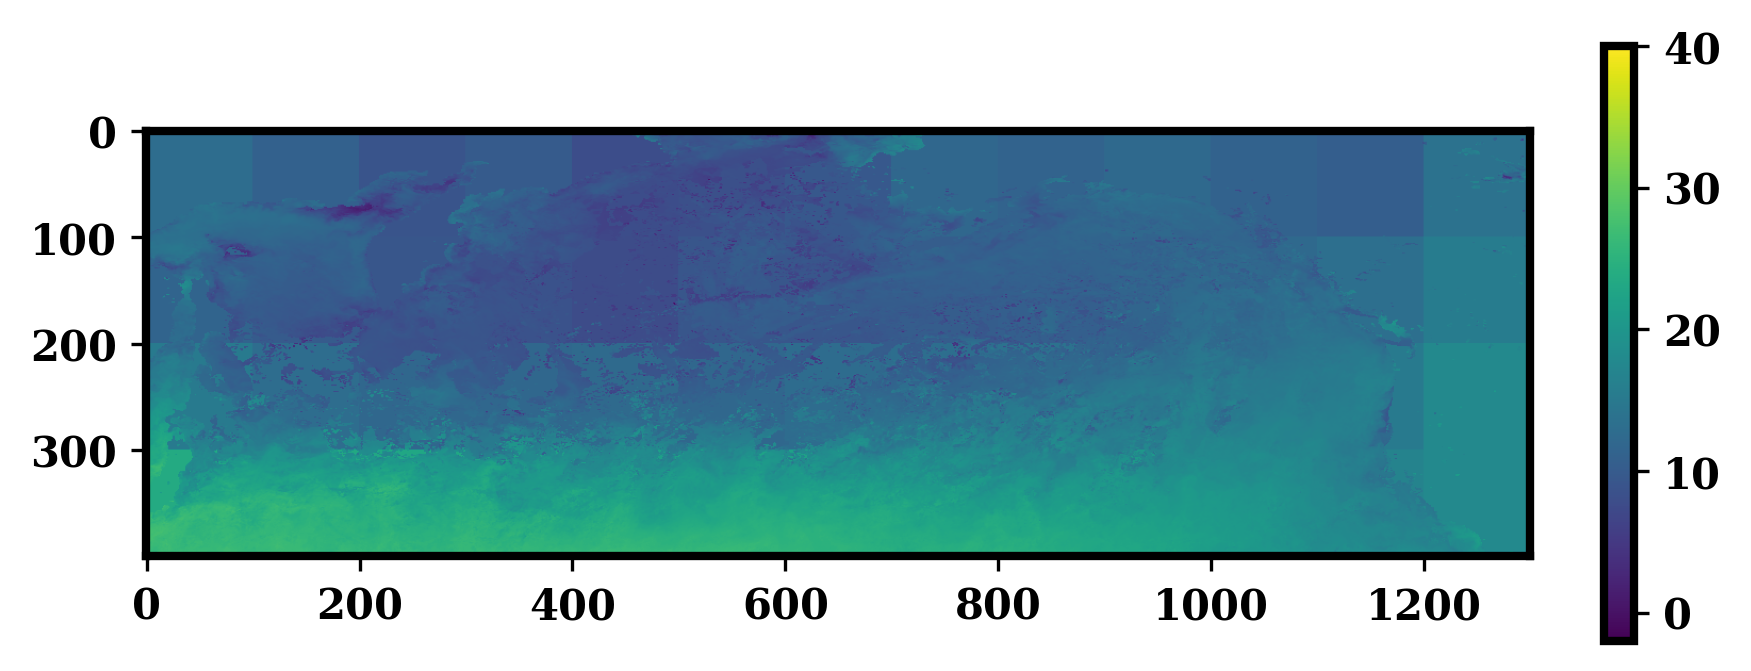

In [213]:
d = [torch.where(torch.isfinite(x) == True, x, torch.nanmean(x)) for x in mask_patches]
for idx,x in enumerate(d):
    if idx == 0:
        e = x
    else:
        e = torch.cat((e,x))
e = e.unsqueeze(1)
e.shape

ya = foldit(e)
plt.imshow(ya[0,0],vmin=-2,vmax=40)
plt.colorbar(fraction=.02)

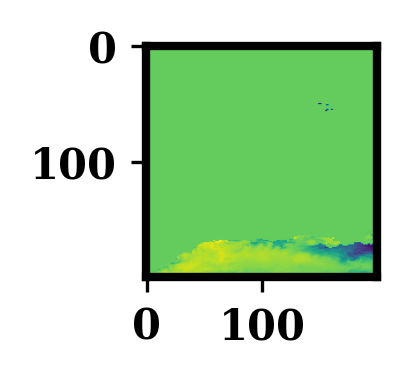

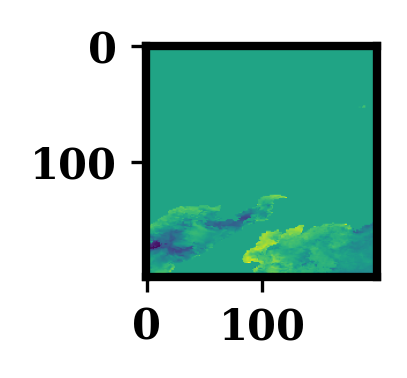

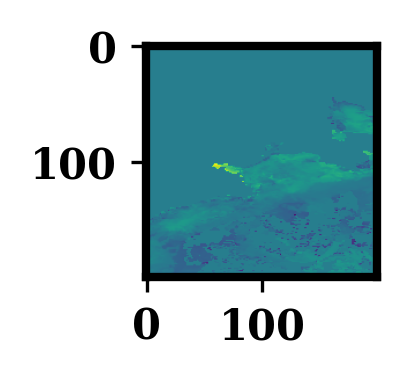

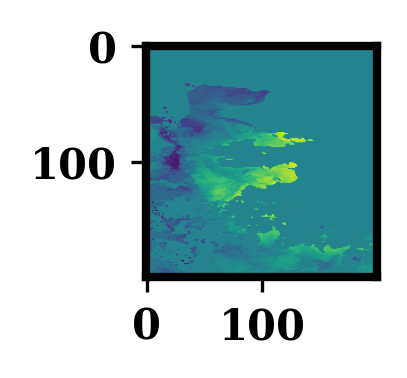

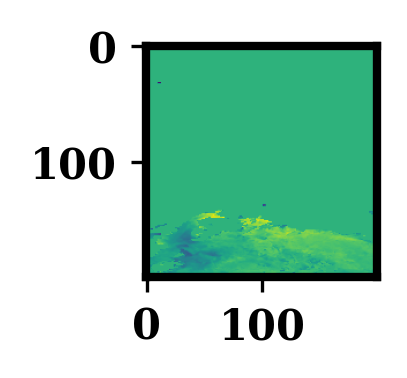

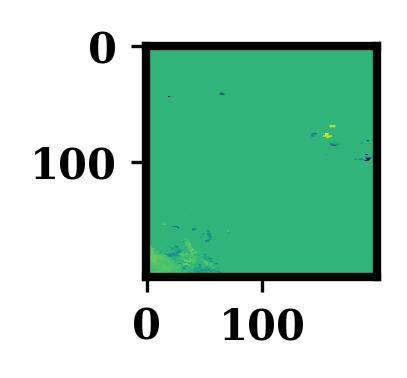

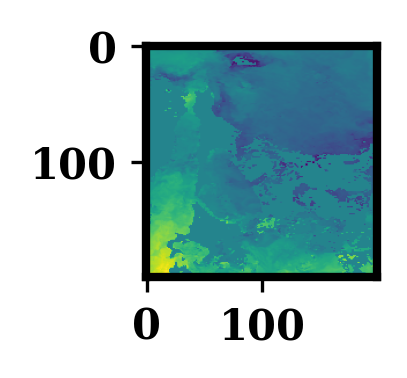

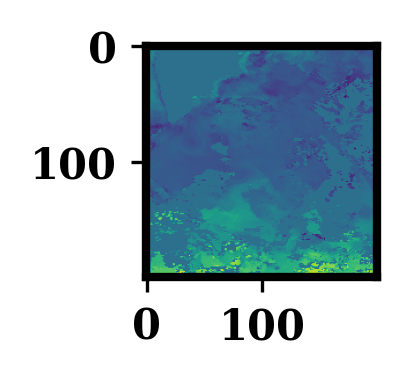

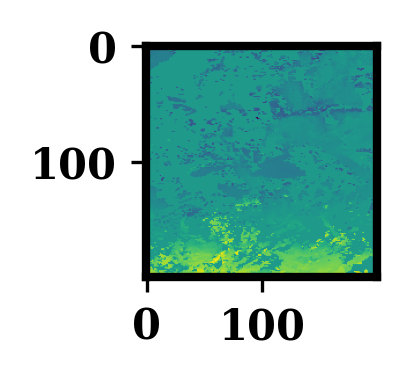

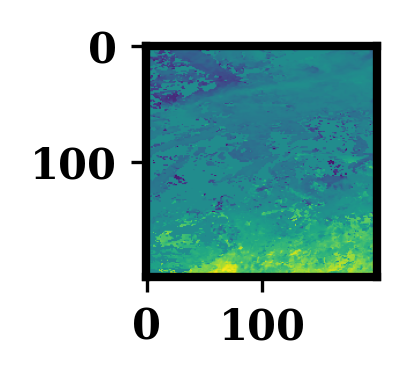

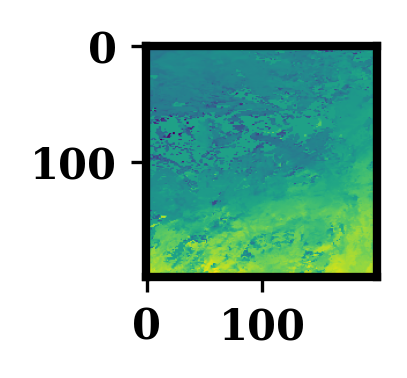

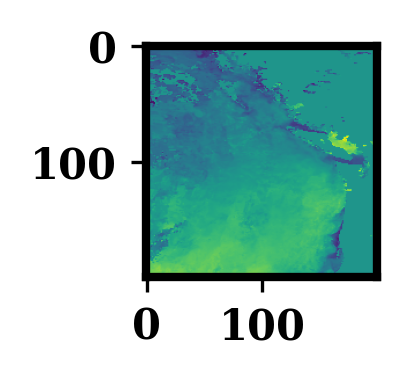

In [180]:
for i in range(mask_patches.shape[0]):
    c = mask_patches[i,0] 
    c = torch.where(torch.isfinite(c) == True, c, torch.nanmean(c))
    plt.figure(figsize=(1,1))
    plt.imshow(c)